In [1]:
import argparse
import os
import pickle
import shutil

import sklearn.metrics as metrics
import torch

import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain
import sys

In [2]:
import pickle
import torch
import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain


# Step 1: Argument Parsing (based on your explainer_main.py setup)
def arg_parse():
    # Check if we are in a Jupyter notebook environment

    # Manually set the arguments for notebook usage
    class Args:
        dataset = "synthetic"
        bmname = "synthetic"
        pkl_fname = None
        logdir = "log"
        ckptdir = "ckpt"
        cuda = "0"
        gpu = False
        num_epochs = 100
        hidden_dim = 20
        output_dim = 20
        num_gc_layers = 3
        dropout = 0.01
        mask_act = "sigmoid"
        explain_node = None
        graph_idx = -1
        graph_mode = True  # Graph classification mode
        align_steps = 1000
        opt = "adam"
        opt_scheduler = "none"
        method = "base"  # Method attribute was missing
        name_suffix = ""
        explainer_suffix = ""
        clip = 2.0
        lr = 0.1
        batch_size = 20
        bias = True
        clean_log = False
        bn = False
        mask_bias = False

    return Args()


# Step 2: Function to Initialize Explainer and Model
def initialize_explainer():
    # Load the arguments
    prog_args = arg_parse()

    if prog_args.gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = prog_args.cuda
        print("Using GPU")
    else:
        print("Using CPU")

    # Load a model checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # get computation graph

    input_dim = cg_dict["feat"].shape[2]
    num_classes = cg_dict["pred"].shape[2]

    print("Loaded model from checkpoint")
    print("Input dim:", input_dim, "; Num classes:", num_classes)

    # Build the model
    if prog_args.graph_mode:
        model = models.GcnEncoderGraph(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )
    else:
        model = models.GcnEncoderNode(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )

    # Load the model state
    model.load_state_dict(ckpt["model_state"])

    # Initialize the explainer
    explainer = explain.Explainer(
        model=model,
        adj=cg_dict["adj"],
        feat=cg_dict["feat"],
        label=cg_dict["label"],
        pred=cg_dict["pred"],
        train_idx=cg_dict["train_idx"],
        args=prog_args,
        writer=None,  # No Tensorboard logging for simplicity
        print_training=True,
        graph_mode=prog_args.graph_mode,
        graph_idx=prog_args.graph_idx,
    )

    return explainer


# Step 3: Prototype Extraction Function
import torch
import numpy as np


# Function to extract prototype (non-masked nodes and features)
def extract_prototype(graph_idx, explainer):
    """
    Extract and save the prototype for a given graph.

    Args:
        graph_idx: Index of the graph to explain
        explainer: The explainer instance used to generate explanations

    Returns:
        prototype: A dictionary containing important nodes and their corresponding important features
    """
    print(f"Explaining graph {graph_idx}...")

    # Explain the graph and get the masked adjacency matrix
    masked_adj = explainer.explain(node_idx=0, graph_idx=graph_idx, graph_mode=True)

    # If masked_adj is a numpy array, convert it to a tensor
    if isinstance(masked_adj, np.ndarray):
        masked_adj = torch.tensor(masked_adj)

    # Get feature mask if available
    mask_feat = explainer.mask_feat if hasattr(explainer, "mask_feat") else None

    # Retain only the non-masked nodes (summing over axis 1 to get the importance of each node)
    node_importance = masked_adj.sum(dim=1)  # Sum over rows to get node importance
    important_nodes = torch.nonzero(
        node_importance > 0
    ).squeeze()  # Keep important nodes

    # Retain only non-masked features for important nodes
    important_features = explainer.feat[important_nodes]
    if mask_feat is not None:
        important_features = important_features * mask_feat[important_nodes]

    # Prepare the prototype data
    prototype = {
        "important_nodes": important_nodes.cpu().numpy(),
        "important_features": important_features.cpu().numpy(),
    }

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype


# Initialize the explainer
explainer = initialize_explainer()

# Step 4: Generate prototypes for test graphs (replace with your test graph indices)
test_graph_indices = [0, 1, 2, 3]  # Example test graph indices

# Extract prototypes
for graph_idx in test_graph_indices:
    prototype = extract_prototype(graph_idx, explainer)
    print(prototype)
    print(f"Prototype for graph {graph_idx}: {prototype}")

Using CPU
loading model
ckpt/synthetic_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/synthetic_base_h20_o20.pth.tar'
Loaded model from checkpoint
Input dim: 4 ; Num classes: 360
Explaining graph 0...
Graph predicted label:  3


/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


epoch:  0 ; loss:  38.832977294921875 ; mask density:  0.7541658878326416 ; pred:  tensor([2.7121e-01, 1.1259e-01, 3.0177e-01, 2.9017e-01, 5.8613e-05, 5.8367e-05,
        7.5731e-05, 6.9554e-05, 7.3809e-05, 6.9801e-05, 6.9801e-05, 7.4949e-05,
        6.2744e-05, 6.1770e-05, 6.6532e-05, 7.6009e-05, 6.6805e-05, 5.8987e-05,
        6.1167e-05, 6.4300e-05, 8.1089e-05, 6.5392e-05, 6.1828e-05, 6.7291e-05,
        5.9722e-05, 5.6513e-05, 6.9925e-05, 6.6387e-05, 7.3610e-05, 8.3066e-05,
        8.7451e-05, 7.2920e-05, 6.7975e-05, 4.7342e-05, 6.9791e-05, 5.8225e-05,
        5.7029e-05, 6.6784e-05, 6.0305e-05, 6.1179e-05, 6.1969e-05, 7.0203e-05,
        7.0110e-05, 6.4845e-05, 5.2344e-05, 6.7928e-05, 6.5336e-05, 4.9725e-05,
        5.7861e-05, 6.6667e-05, 7.2139e-05, 5.6930e-05, 7.9847e-05, 9.6403e-05,
        5.0272e-05, 6.4220e-05, 6.2585e-05, 7.8615e-05, 4.7379e-05, 4.7456e-05,
        6.7687e-05, 8.0113e-05, 1.0092e-04, 6.4778e-05, 6.1431e-05, 7.5514e-05,
        8.5024e-05, 8.2450e-05, 6.367

/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


tensor([2.7605e-01, 1.4934e-01, 2.8050e-01, 2.2787e-01, 1.7631e-04, 1.6039e-04,
        2.2485e-04, 2.0328e-04, 1.9836e-04, 2.0102e-04, 1.8850e-04, 1.8980e-04,
        1.8674e-04, 1.6755e-04, 1.7419e-04, 1.8510e-04, 1.7379e-04, 1.7383e-04,
        1.6209e-04, 1.7242e-04, 2.1144e-04, 1.7195e-04, 1.8196e-04, 1.8733e-04,
        1.6350e-04, 1.4462e-04, 1.7301e-04, 1.8249e-04, 1.9938e-04, 2.1418e-04,
        2.1903e-04, 1.9306e-04, 1.7014e-04, 1.4324e-04, 1.8406e-04, 1.4606e-04,
        1.8204e-04, 1.8188e-04, 1.7925e-04, 1.7736e-04, 1.5265e-04, 1.8670e-04,
        1.9234e-04, 1.6209e-04, 1.4887e-04, 1.9237e-04, 1.7202e-04, 1.3980e-04,
        1.6406e-04, 2.0568e-04, 2.0104e-04, 1.7529e-04, 2.2421e-04, 2.8029e-04,
        1.5208e-04, 1.8942e-04, 1.7464e-04, 2.1950e-04, 1.4889e-04, 1.4126e-04,
        1.9163e-04, 2.1159e-04, 2.7047e-04, 1.7180e-04, 1.7013e-04, 2.1208e-04,
        2.2507e-04, 2.1963e-04, 1.7521e-04, 2.1518e-04, 2.2183e-04, 1.8912e-04,
        1.7859e-04, 1.8133e-04, 2.0693e-

In [3]:
# from dataset import GraphDataset, create_dataset

# pyg_dataset = GraphDataset(
#     torch.load("my_data/cycle_line_star_complete_1.pt", weights_only=False)
# )

In [4]:
from torch_geometric.data import Data


import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse


def reconstruct_dataset_from_ckpt(prog_args):
    # Use io_utils to load the checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # Get computation graph data

    # Extract adjacency matrices, features, and labels
    adj = cg_dict["adj"]  # Adjacency matrices
    feat = cg_dict["feat"]  # Node features
    labels = cg_dict["label"]  # Labels

    dataset = []
    for i in range(len(adj)):
        # Convert adjacency matrix to edge_index format (from dense to sparse)
        adj_matrix = torch.tensor(adj[i])
        edge_index, edge_attr = dense_to_sparse(adj_matrix)  # Convert to edge_index

        # Get node features and labels
        node_features = torch.tensor(feat[i])
        graph_label = torch.tensor(labels[i])

        # Create PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, y=graph_label)

        dataset.append(data)

    return dataset


prog_args = arg_parse()
pyg_dataset = reconstruct_dataset_from_ckpt(prog_args)

loading model
ckpt/synthetic_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/synthetic_base_h20_o20.pth.tar'


/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_63398/4131874458.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_matrix = torch.tensor(adj[i])
/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_63398/4131874458.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(feat[i])
/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_63398/4131874458.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph_label = torch.tensor(labels[i])


In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

In [6]:
idx = 0

Graph predicted label:  3
epoch:  0 ; loss:  38.80642318725586 ; mask density:  0.7312619090080261 ; pred:  tensor([2.7715e-01, 1.0263e-01, 3.0123e-01, 2.9423e-01, 6.1166e-05, 6.1687e-05,
        8.0302e-05, 6.9532e-05, 7.5751e-05, 7.1649e-05, 7.1460e-05, 7.9039e-05,
        6.3291e-05, 6.3082e-05, 6.7681e-05, 7.8159e-05, 6.9424e-05, 5.7410e-05,
        6.3934e-05, 6.5509e-05, 8.4011e-05, 6.6543e-05, 6.2094e-05, 6.8555e-05,
        5.9100e-05, 5.6505e-05, 7.0943e-05, 6.7484e-05, 7.3457e-05, 8.3180e-05,
        9.0615e-05, 7.3928e-05, 6.7799e-05, 4.7348e-05, 7.1112e-05, 5.7475e-05,
        5.7862e-05, 6.6064e-05, 6.3120e-05, 6.4296e-05, 6.2429e-05, 6.9372e-05,
        7.0260e-05, 6.4756e-05, 5.3681e-05, 6.6792e-05, 6.6758e-05, 4.9910e-05,
        5.7115e-05, 6.8712e-05, 7.2182e-05, 5.8770e-05, 7.8678e-05, 9.7382e-05,
        5.0144e-05, 6.5489e-05, 6.4045e-05, 8.2502e-05, 4.7809e-05, 4.7420e-05,
        6.7926e-05, 8.0104e-05, 1.0115e-04, 6.7209e-05, 6.3007e-05, 7.7029e-05,
        8.54

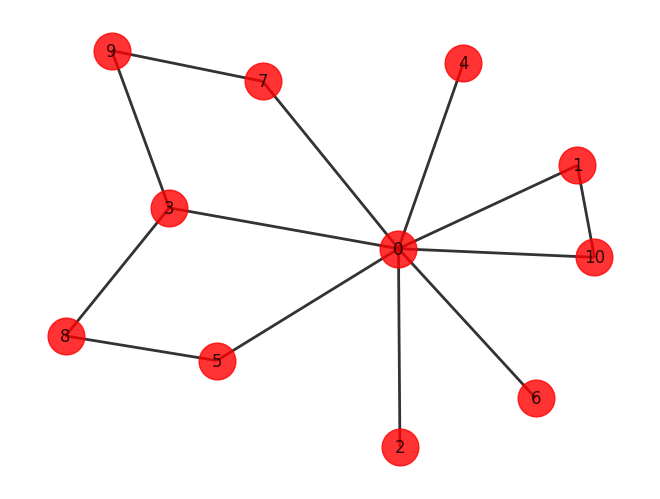

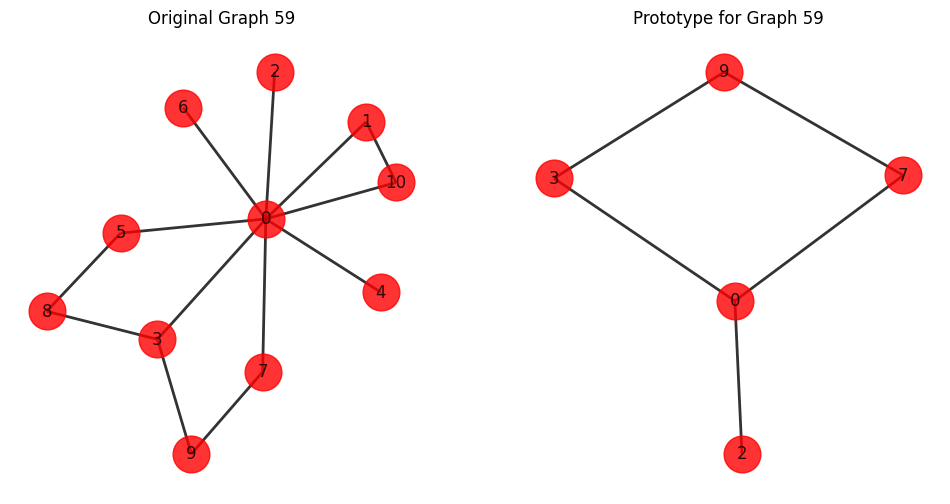

In [154]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx


def explain_and_plot_graph(graph_idx, explainer, threshold=0.9):
    masked_adjs, graphs = explainer.explain_graphs(graph_indices=[graph_idx])

    masked_adj = masked_adjs[0]
    original_G = graphs[0]

    pos = nx.spring_layout(original_G)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    nx.draw(
        original_G,
        pos,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Original Graph {graph_idx}")

    plt.subplot(1, 2, 2)

    prototype_G = io_utils.denoise_graph(
        masked_adj,
        node_idx=0,
        feat=explainer.feat[graph_idx],
        threshold=threshold,
        max_component=False,
    )

    pos = nx.spring_layout(prototype_G)

    nx.draw(
        prototype_G,
        pos,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Prototype for Graph {graph_idx}")

    plt.show()
    return (original_G, prototype_G)


graph_idx = 59
original_G, prototype_G = explain_and_plot_graph(graph_idx, explainer, 0.8)

In [155]:
# graph_data = [from_networkx(original_G), from_networkx(prototype_G)]

with open("graphs/graph9_star.pkl", "wb") as f:
    pickle.dump((original_G, prototype_G), f)